#### Import libraries.

In [1]:

import time
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt


#### Load the dataset.

In [2]:

df = pd.read_csv("../dataset/original-noneeg-dataset.csv", sep="|", dtype = {"hr": "float64", "label": "int8"})


#### Display the dataset size.

In [3]:
df.shape

(41992, 2)

#### Define a helper function to convert the set data to the required format to perform the undersampling.

In [4]:

number_of_steps = 30

def build_time_window_structure(df):
    # Splits the dataset into "time windows" to be used as a time series list.
    # The function groups each 30 dataset records (CSV lines) into one record.
    # Each record contains 30 steps and each step contains 1 feature value.
    # Parameters:
    #    df: Dataframe to be splitted.
    # Return:
    #    First list contains all time windows.
    #    Second list contains all target values.
    print("\nStarting build_time_window_structure function.")
    initial_line_number = 0
    first_feat_index = 0
    last_feat_index = 1
    X_array = []
    y_array = []
    while initial_line_number < len(df["label"]):
        target_value = df["label"][initial_line_number]
        sub_matrix = df.iloc[initial_line_number : (initial_line_number + number_of_steps), first_feat_index : last_feat_index]
        sub_matrix_values = sub_matrix.values
        new_line = sub_matrix_values.flatten()
        size_diff = number_of_steps - len(new_line)
        if size_diff > 0:
            last_value = new_line[len(new_line) - 1]
            new_line = np.append(new_line, [last_value] * size_diff)
        X_array.append(new_line)
        y_array.append(target_value)
        initial_line_number += number_of_steps
    print("Quantity of samples (features) => ", len(X_array))
    print("Quantity os samples (labels) => ", len(y_array))
    print("Finishing build_time_window_structure function.")
    return X_array, y_array


#### Perform undersampling to balance the dataset.

In [5]:

# Correct dataset imbalance through undersampling.
print("\nStarting undersampling process...")
X_list, y_list = build_time_window_structure(df)
rus = RandomUnderSampler(random_state = 42)
X_arr = np.array(X_list)
y_arr = np.array(y_list)
X_resampled, y_resampled = rus.fit_resample(X_arr, y_arr)
print("\nQuantity of resampled samples => ", len(y_resampled))



Starting undersampling process...

Starting build_time_window_structure function.
Quantity of samples (features) =>  1400
Quantity os samples (labels) =>  1400
Finishing build_time_window_structure function.

Quantity of resampled samples =>  800


#### Train a Multilayer Perceptron model and evaluate the metrics.
- Layer architecture => Dense (100) + Dense (200) + Dense (300) + Dense (200) + Dense (100) + Dense (4)
- No data augmentation.

In [6]:

def create_baseline() :
    model = Sequential()
    model.add(Dense(100, input_shape = (30,), activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(200, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(300, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(200, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(100, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    return model

# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

pt = PowerTransformer()

# Train the MLP model and evaluate it.
start_time = time.time()
print("\nStarting training...\n")
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20, restore_best_weights = True)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
y_predclass_for_report = []
y_testclass_for_report = []
history_by_fold = []
fold_number = 1
for train_index, test_index in skf.split(X_resampled, y_resampled):
    print("\nTraining fold {}".format(fold_number))
    X_train_scaled = pt.fit_transform(X_resampled[train_index])
    X_test_scaled = pt.transform(X_resampled[test_index])
    model = create_baseline()
    history = model.fit(X_train_scaled, y_resampled[train_index], validation_split = 0.1,
                            epochs = 300, batch_size = 64, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_scaled, y_resampled[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X_test_scaled, y_resampled[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    y_predclass_for_report.extend(np.argmax(model.predict(X_resampled[test_index]), axis = 1))
    y_testclass_for_report.extend(y_resampled[test_index])
    history_by_fold.append(history)
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))

print("\nEvaluate other metrics:")
print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))



Starting training...


Training fold 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 300)               60300     
                                                                 
 dense_3 (Dense)             (None, 200)               60200     
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
Total params: 1

#### Train a Multilayer Perceptron model and evaluate the metrics.
- Layer architecture => Dense (100) + Dense (200) + Dense (300) + Dense (200) + Dense (100) + Dense (4)
- Data augmentation (5x).

In [7]:

def create_v1() :
    model = Sequential()
    model.add(Dense(100, input_shape = (30,), activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(200, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(300, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(200, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(100, activation = 'relu', kernel_initializer = "he_uniform"))
    model.add(Dense(4, activation = 'softmax'))
    model.summary()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    return model

# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Normalize data using PowerTransformer method.
pt = PowerTransformer()

# Train the MLP model and evaluate it.
start_time = time.time()
print("\nStarting training...\n")
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 30, restore_best_weights = True)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
y_predclass_for_report = []
y_testclass_for_report = []
history_by_fold = []
fold_number = 1
for train_index, test_index in skf.split(X_resampled, y_resampled):
    print("\nTraining fold {}".format(fold_number))
    # Data augmentation (5x).
    X_oversampled, y_oversampled = resample(X_resampled[train_index],
                                            y_resampled[train_index],
                                            replace = True,
                                            n_samples = 4000,
                                            stratify = y_resampled[train_index],
                                            random_state = 42)
    X_train_scaled = pt.fit_transform(X_oversampled)
    X_test_scaled = pt.transform(X_resampled[test_index])
    model = create_v1()
    history = model.fit(X_train_scaled, y_oversampled, validation_split = 0.05,
                            epochs = 300, batch_size = 64, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_scaled, y_oversampled, verbose = 0)
    _, test_accuracy = model.evaluate(X_test_scaled, y_resampled[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    y_predclass_for_report.extend(np.argmax(model.predict(X_test_scaled), axis = 1))
    y_testclass_for_report.extend(y_resampled[test_index])
    history_by_fold.append(history)
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))

print("\nEvaluate other metrics:")
print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))



Starting training...


Training fold 1
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 100)               3100      
                                                                 
 dense_61 (Dense)            (None, 200)               20200     
                                                                 
 dense_62 (Dense)            (None, 300)               60300     
                                                                 
 dense_63 (Dense)            (None, 200)               60200     
                                                                 
 dense_64 (Dense)            (None, 100)               20100     
                                                                 
 dense_65 (Dense)            (None, 4)                 404       
                                                                 
Total params:

#### Show loss history by epochs.

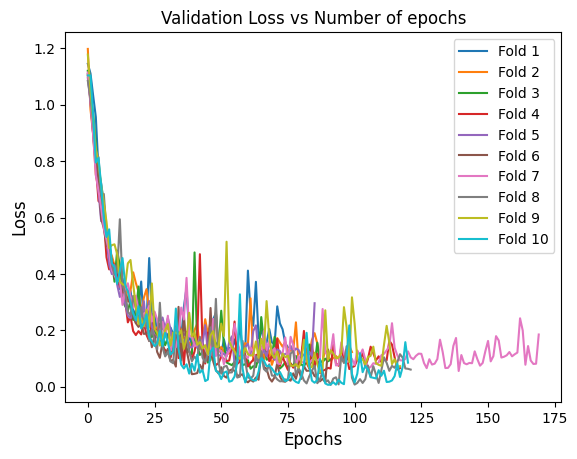

In [8]:

# Plot loss history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_loss"], label = "Fold {}".format(i + 1))
plt.title("Validation Loss vs Number of epochs", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.show()


#### Show accuracy history by epochs.

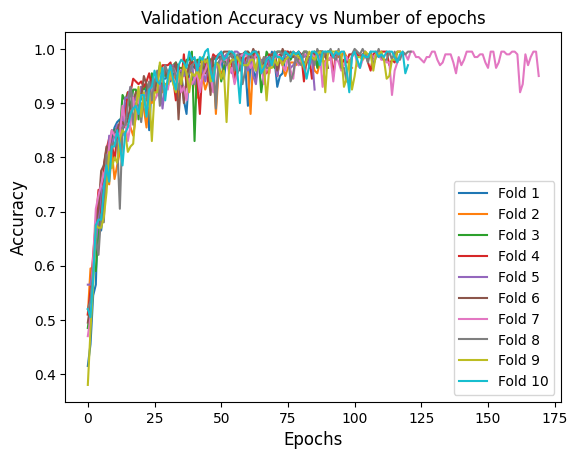

In [9]:

# Plot accuracy history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_accuracy"], label = "Fold {}".format(i + 1))
plt.title("Validation Accuracy vs Number of epochs", fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()
plt.show()
